# Gaussian Processes

If one is ready to assume the data available is such that the variable being fit is Gaussian for any pair of samples taken, one can use fit the data and obtain a reliable uncertainty with a very small set of assumptions.

For this example, we will use the dataset collected in Mauna Loa showing the amount of CO2 present in the atmosphere. This data may be downloaded from https://gml.noaa.gov/ccgg/trends/data.html and it should already be available in this repository.


In [ ]:
#!wget https://raw.githubusercontent.com/European-XFEL/ml-lecture-oct-2023/main/co2_weekly_mlo.txt

We can take a quick look at the file to see what is inside:

In [1]:
with open("co2_weekly_mlo.txt", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i > 60: # let's print only the first 60 lines only
            break
        print(line[:-1])

# --------------------------------------------------------------------
# USE OF NOAA GML DATA
# 
# These data are made freely available to the public and the
# scientific community in the belief that their wide dissemination
# will lead to greater understanding and new scientific insights.
# The availability of these data does not constitute publication
# of the data.  NOAA relies on the ethics and integrity of the user to
# ensure that GML receives fair credit for their work.  If the data 
# are obtained for potential use in a publication or presentation, 
# GML should be informed at the outset of the nature of this work.  
# If the GML data are essential to the work, or if an important 
# result or conclusion depends on the GML data, co-authorship
# may be appropriate.  This should be discussed at an early stage in
# the work.  Manuscripts using the GML data should be sent to GML
# for review before they are submitted for publication so we can
# ensure that the quality and limitation

We start by loading the necessary Python modules.

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic

Let us now load the data downloaded using pandas. If you are not familiar with Pandas, take a look at the documentation for a quick introduction at https://pandas.pydata.org/docs/user_guide/10min.html

We can easily parse the data file using Pandas' read_csv function. It would require some coding to do it manually. As Pandas does not detect the column names, we have to specify it manually in the names parameter below.

In [3]:
data = pd.read_csv("co2_weekly_mlo.txt",
                   delim_whitespace=True,
                   comment='#',
                   header=None,
                   names=["year", "month", "day", "decimal",
                          "co2",
                          "ndays",
                          "last_year", "last_decade",
                          "increase"])

Let's print out the dataset read first.

In [4]:
data

,year,month,day,decimal,co2,ndays,last_year,last_decade,increase
0,1974,5,19,1974.3795,333.37,5,-999.99,-999.99,50.40
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.35,5,-999.99,-999.99,49.60
3,1974,6,9,1974.4370,332.20,7,-999.99,-999.99,49.65
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.06
...,...,...,...,...,...,...,...,...,...
2482,2021,12,12,2021.9466,416.45,7,414.00,392.19,137.16
2483,2021,12,19,2021.9658,417.49,6,414.86,392.54,137.93
2484,2021,12,26,2021.9849,417.46,7,415.32,392.43,137.66
2485,2022,1,2,2022.0041,417.43,6,415.44,393.18,137.40


We can plot this fairly easily using Matplotlib.

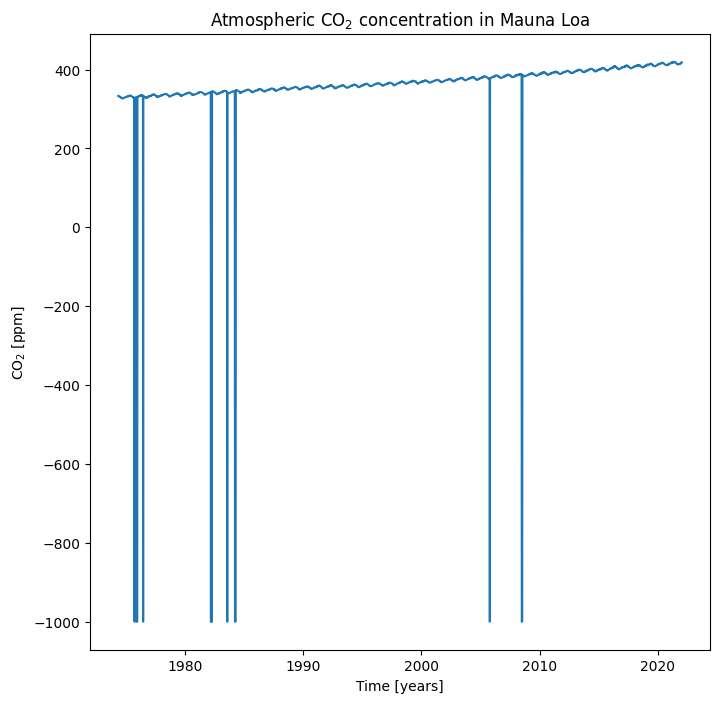

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
data.plot(x="decimal", y="co2", legend=False, ax=ax)
ax.set(xlabel="Time [years]", ylabel=r"CO$_2$ [ppm]", title="Atmospheric CO$_2$ concentration in Mauna Loa")
plt.show()

The spikes are related to missing data. We can clean those up and plot again.

In [6]:
data = data[data.co2 > -999]

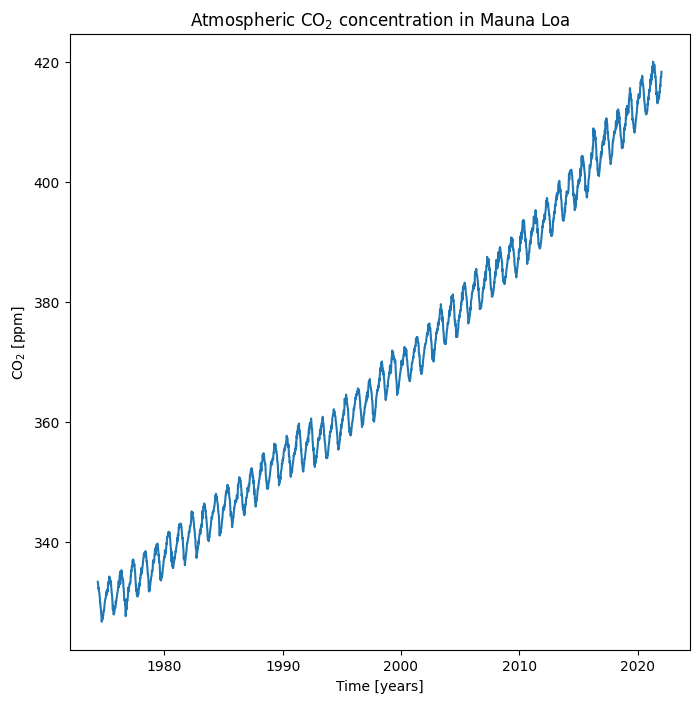

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
data.plot(x="decimal", y="co2", legend=False, ax=ax)
ax.set(xlabel="Time [years]", ylabel=r"CO$_2$ [ppm]", title="Atmospheric CO$_2$ concentration in Mauna Loa")
plt.show()

That's better.

We can now try to model this behaviour with Gaussian Processes. The key parameter we must choose is the covariance matrix analytic form, which establishes how correlated two points in the time axis are.

One simple assumption would be that two values of the CO2 concentration are highly correlated they happened at close by times. We use a Gaussian-based model (named here "Radial Basis Function", as this does not refer to a probability distribution) to establish that if two points are one year apart they are likely to be highly correlated.

Additionally, we assume that there is a correlation between points within certain period, since we know that data from the same season in an year is expected to be correlated to data if that same season in the year (ie: CO$_2$ emissions have a rough periodicity of one year due to the season changes).

Another term of the covariance matrix must be related to the random noise appearing in the data.

All those assumptions can be motivated by an analysis of the covariance matrix of the data. That is, we can take the covariance matrix of all the data points and analyse it to establish whether our assumptions here are valid or not. A very long and detailed explanation on this point can be found in Bishop (2006), which has a very pedagogical chapter on Gaussian Processes. Online resources can be found on: http://www.gaussianprocess.org/

Note that all of those are very strong assumptions, but they are made directly on the covariance matrix of the fit function. The actual numbers used below are taken from an example, but they will be optimized in the fit below (unless explicitly asked not to).

Note: this notebook is a simplified example with extra explanations, with lots of material taken from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html -- take a look at the original example for more details.

We also assume the data within an year from each other is highly correlated and should show a periodicity of 1 year.

In [60]:
# Kernel with parameters given in GPML book

# these hyper parameters are optimised in the GP fit
# we provide here only a starting value

# Kernel with optimized initial parameters
k1 = 50.0 ** 2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = (
    2.0 ** 2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)  # seasonal component
# medium term irregularities
k3 = 0.5 ** 2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1 ** 2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1 ** 2, noise_level_bounds=(1e-5, np.inf)
)  # noise terms
kernel = k1 + k2 + k3 + k4

# simpler kernel: RBF kernel with white noise on likelihood
# what happens if you use this instead?
#kernel = (10.0 ** 2 * RBF(length_scale=10.0)
#          + WhiteKernel(noise_level=1**2, noise_level_bounds=(1e-5, np.inf))
#         )

The kernel hyper-parameters are:

In [61]:
print(kernel)

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)


We can now fit the data that we have. But let us not fit the full data: we can fit data using only information until 2014 to use the period between 2014 and now as an estimate of the fit quality.

In [63]:
fit_data = data.loc[data.year <= 2014, :]

In [64]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
time = fit_data.decimal.to_numpy()[:, np.newaxis]
co2 = fit_data.co2.to_numpy()[:, np.newaxis]
gp = gp.fit(time, co2)

These are the hyper-parameters after the fit and the log-likelihood given the data:

In [65]:
print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 3.25**2 * RBF(length_scale=37.7) + 0.175**2 * RBF(length_scale=291) * ExpSineSquared(length_scale=1.59, periodicity=1) + 0.319**2 * RationalQuadratic(alpha=0.00134, length_scale=6.47) + 0.0121**2 * RBF(length_scale=0.02) + WhiteKernel(noise_level=0.000209)
Log-marginal-likelihood: 5275.122


Now we can use the fit model to predict how the CO2 concentration will evolve at other times.

In [66]:
new_time = np.linspace(time.min(), time.max()+20, 1000)[:, np.newaxis]
co2_pred, co2_std = gp.predict(new_time, return_std=True)

First let's plot the prediction with uncertainty only:

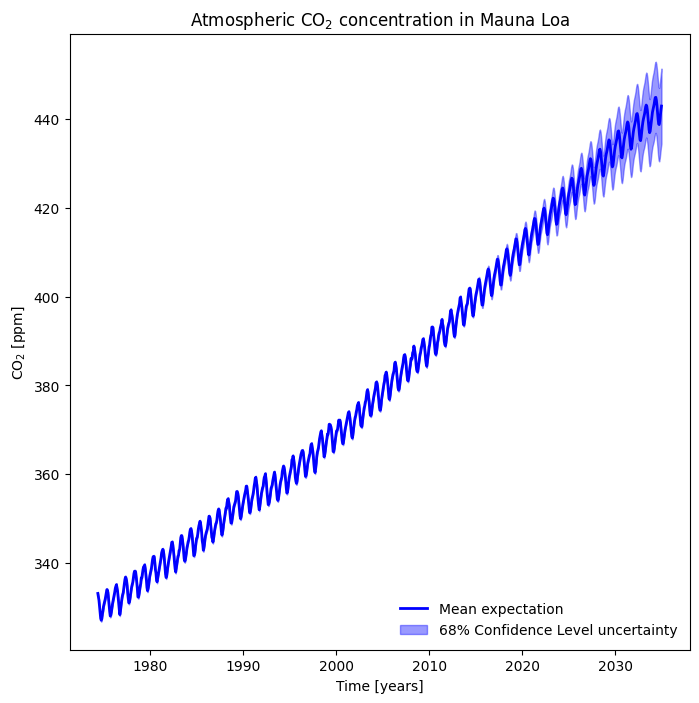

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(new_time[:,0],
        co2_pred,
        color="b",
        lw=2,
        label="Mean expectation")
ax.fill_between(new_time[:,0],
                co2_pred - co2_std,
                co2_pred + co2_std,
                color="b",
                alpha=0.4,
                label="68% Confidence Level uncertainty")
ax.set(xlabel="Time [years]", ylabel=r"CO$_2$ [ppm]", title="Atmospheric CO$_2$ concentration in Mauna Loa")
ax.legend(frameon=False, loc="lower right")
plt.show()

Now let's plot the actual dat above it, to check how far off we are. Let's also plot the training data and full data separately, so we can see where data not used in the fit starts: this is where our uncertainty should start becoming bigger if everything worked out correctly.

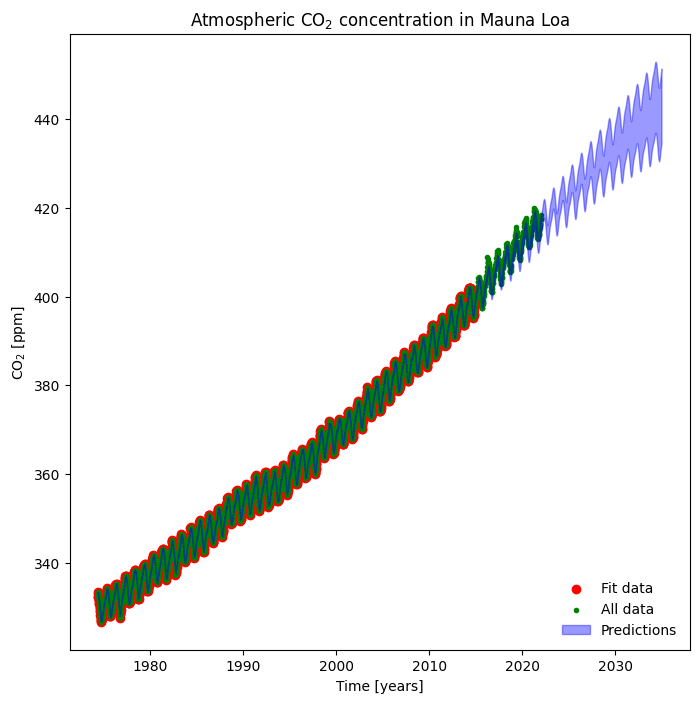

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(time, co2, color='red', marker='o', label="Fit data")
ax.scatter(data.decimal, data.co2, color='green', marker='.', label="All data")
ax.fill_between(new_time[:,0],
                co2_pred - co2_std,
                co2_pred + co2_std,
                color="b",
                alpha=0.4,
                label="Predictions")
ax.set(xlabel="Time [years]", ylabel=r"CO$_2$ [ppm]", title="Atmospheric CO$_2$ concentration in Mauna Loa")
ax.legend(frameon=False, loc="lower right")
plt.show()

Try changing the kernel above and check what happens. Notice how large an effect the kernel definition has in the results!

The kernel is one of our key assumptions here!

Many more details on the kernel selection as well as further details in this example can be seen in the following references:

https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

To read more on Gaussian Processes:

http://www.gaussianprocess.org/gpml/chapters/RW.pdf